In [1]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [2]:
net = ContTempNetwork.load('fig3_network250')
net_heat = ContTempNetwork.load('fig3_network250_heat')

In [3]:
slow_lamdas=np.logspace(-10,-4,200)
between_slow_lamdas=np.linspace(-10,-4,200)

lamdas=np.logspace(-5,1,200)
between_lamdas=np.linspace(-5,1,200)

In [6]:
list_forw_flows = []

for i, l in enumerate(slow_lamdas):
    with open(f'//scratch/tmp/180/skoove/experiment250_static_weighted_heat/T_slow/T{l:.11f}', 'rb') as f:
        T_list = pickle.load(f)['T']

    list_forw_flows.append(FlowIntegralClustering(T_list=T_list,
                                  time_list=net.times,
                                  verbose=False))
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [7]:
multi_res_slow = {}

for i, lamda in enumerate(slow_lamdas):
    flowintegralclustering = list_forw_flows[i]
    clustering = SparseClustering(p1=flowintegralclustering.p1, p2=None,
                        T=flowintegralclustering.T_list[-1], S=flowintegralclustering.I_list[0])
    clusters, stabilites, seeds = parallel_clustering.compute_parallel_clustering(clustering, num_repeat=50, nproc=10, 
                                verbose=False, n_meta_iter_max=1000, 
                                n_sub_iter_max=1000, 
                                clust_verbose=False, print_num_loops=False)
    multi_res_slow[lamda] = clusters
    print(i)

file=f'//scratch/tmp/180/skoove/experiment250_static_weighted_heat/clusters_slow'
with open(file, 'wb') as fopen:
    pickle.dump(multi_res_slow, fopen)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [4]:
with open('//scratch/tmp/180/skoove/experiment250_static_weighted_heat/clusters_slow', 'rb') as f:
    multi_res_static_weighted_heat = pickle.load(f)
    
avg_csize_forw_static_weighted_heat = [np.mean([len(c) for c in \
                   multi_res_static_weighted_heat[lamda] if len(c)>1]) for lamda in slow_lamdas]

NVI_forw_static_weighted_heat = [avg_norm_var_information(multi_res_static_weighted_heat[lamda]) for lamda in slow_lamdas]

### Static Clustering 2

In [11]:
p1 = p2 = 1/net.num_nodes * np.ones((net.num_nodes))
P = eye(net.num_nodes, dtype=np.float64).tocsr()
P.data = p1

multi_res_sam = {}


for i, lamda in enumerate(slow_lamdas):
    with open(f'//scratch/tmp/180/skoove/experiment250_static_weighted_heat/T_slow/T{slow_lamdas[i]:.11f}', 'rb') as f:
        T = pickle.load(f)['T'][-1]

    PT = P @ T
    sam = sparse_autocov_mat(PT, p1, p2, PT_symmetric=True)
    S = sam.from_T(T = T, p1 = p1, p2 = p2)
    clustering = SparseClustering(p1=p1, p2=p2,
                        T=T, S=S)
    clusters, stabilites, seeds = parallel_clustering.compute_parallel_clustering(clustering, num_repeat=50, nproc=10, 
                                verbose=False, n_meta_iter_max=1000, 
                                n_sub_iter_max=1000, 
                                clust_verbose=False, print_num_loops=False)
    multi_res_sam[lamda] = clusters

    file=f'//scratch/tmp/180/skoove/experiment250_static_weighted_heat/sam_slow/sam{slow_lamdas[i]:.11f}'
    with open(file, 'wb') as fopen:
        pickle.dump(S, fopen)
    
    print(i)

file=f'//scratch/tmp/180/skoove/experiment250_static_weighted_heat/clusters_sam_slow'
with open(file, 'wb') as fopen:
    pickle.dump(multi_res_sam, fopen)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [12]:
with open('//scratch/tmp/180/skoove/experiment250_static_weighted_heat/clusters_sam_slow', 'rb') as f:
    multi_res_static_weighted_heat_sam = pickle.load(f)
    
avg_csize_forw_static_weighted_heat_sam = [np.mean([len(c) for c in \
                   multi_res_static_weighted_heat_sam[lamda] if len(c)>1]) for lamda in slow_lamdas]

NVI_forw_static_weighted_heat_sam = [avg_norm_var_information(multi_res_static_weighted_heat_sam[lamda]) for lamda in slow_lamdas]

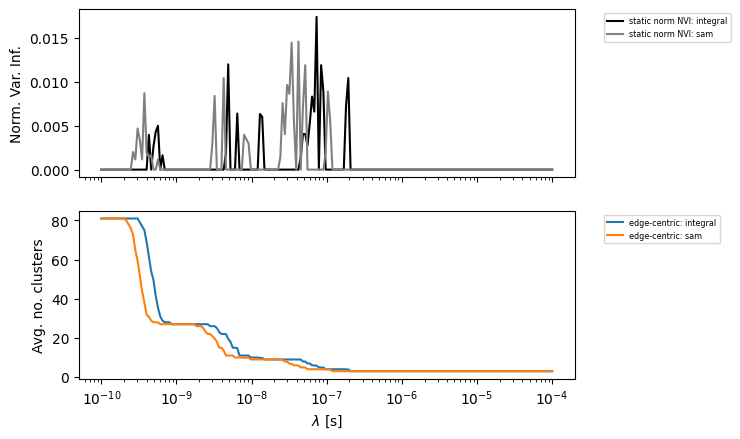

In [14]:
max_NVI_sam = max(NVI_forw_static_weighted_heat_sam)

 
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)

ax1.plot(slow_lamdas, NVI_forw_static_weighted_heat, 'black', label='static norm NVI: integral')
# ax1.vlines(x = [start_81, end_81, start_27, end_27, start_9, end_9, start_5, end_5],
#            ymin = [0, 0, 0, 0, 0, 0, 0, 0], ymax = [max_NVI, max_NVI, max_NVI, max_NVI, max_NVI, max_NVI, max_NVI, max_NVI], colors='purple')
ax1.plot(slow_lamdas, NVI_forw_static_weighted_heat_sam, 'grey', label='static norm NVI: sam')

ax2.plot(slow_lamdas, avg_csize_forw_static_weighted_heat, '-', label='edge-centric: integral')
# ax2.vlines(x = [start_81, end_81, start_27, end_27, start_9, end_9, start_5, end_5],
#            ymin = [0, 0, 0, 0, 0, 0, 0, 0], ymax = [81, 81, 81, 81, 81, 81, 81, 81], colors='purple')
ax2.plot(slow_lamdas, avg_csize_forw_static_weighted_heat_sam, '-', label='edge-centric: sam')

ax1.set_xscale('log')
ax1.set_ylabel('Norm. Var. Inf.')
ax1.legend()
ax1.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

ax2.set_xlabel(r'$\lambda$ [s]')
ax2.set_ylabel('Avg. no. clusters')
ax2.legend()
ax2.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

# Flow Clustering

In [ ]:
# list_forw_flows = []

# for i, l in enumerate(lamdas):
#     with open(f'//scratch/tmp/180/skoove/experiment250_heat/T/T{l:.06f}', 'rb') as f:
#         T_list = pickle.load(f)['T']

#     list_forw_flows.append(FlowIntegralClustering(T_list=T_list,
#                                   time_list=net.times,
#                                   verbose=False))
    
#     print(i)

In [ ]:
# multi_res = {}

# for i, lamda in enumerate(lamdas):
#     flowintegralclustering = list_forw_flows[i]
#     clustering = SparseClustering(p1=flowintegralclustering.p1, p2=None,
#                         T=flowintegralclustering.T_list[-1], S=flowintegralclustering.I_list[0])
#     clusters, stabilites, seeds = parallel_clustering.compute_parallel_clustering(clustering, num_repeat=50, nproc=10, 
#                                 verbose=True, n_meta_iter_max=1000, 
#                                 n_sub_iter_max=1000, 
#                                 clust_verbose=False, print_num_loops=False)
#     multi_res[lamda] = clusters
#     print(i)

# file=f'//scratch/tmp/180/skoove/experiment250_heat/clusters'
# with open(file, 'wb') as fopen:
#     pickle.dump(multi_res, fopen)

In [13]:
with open('//scratch/tmp/180/skoove/experiment250_heat/clusters', 'rb') as f:
    multi_res_heat = pickle.load(f)
    
avg_csize_forw_heat = [np.mean([len(c) for c in \
                   multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas]

NVI_forw_heat = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas]

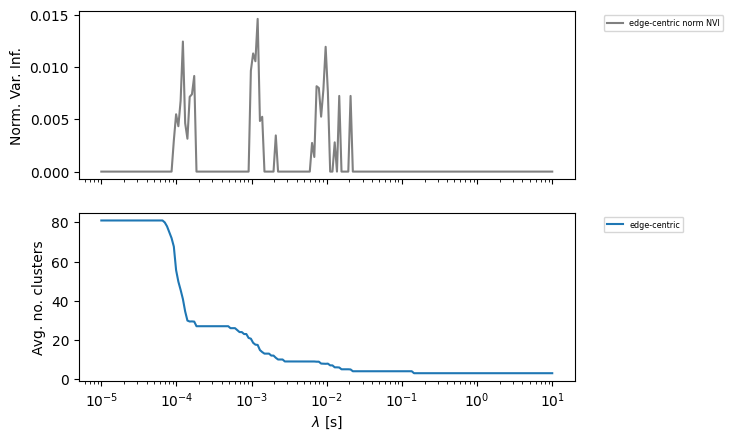

In [14]:
max_NVI = max(NVI_forw_heat)

fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)

    
# ax1.plot(lamdas, NVI_forw_heat, 'black', label='node-centric norm NVI')
# ax1.vlines(x = [start_81, end_81, start_27, end_27, start_9, end_9, start_5, end_5],
#            ymin = [0, 0, 0, 0, 0, 0, 0, 0], ymax = [max_NVI, max_NVI, max_NVI, max_NVI, max_NVI, max_NVI, max_NVI, max_NVI], colors='purple')
ax1.plot(lamdas, NVI_forw_heat, 'grey', label='edge-centric norm NVI')

# ax2.plot(lamdas, avg_csize_forw, '-', label='node-centric')
# ax2.vlines(x = [start_81, end_81, start_27, end_27, start_9, end_9, start_5, end_5],
#            ymin = [0, 0, 0, 0, 0, 0, 0, 0], ymax = [81, 81, 81, 81, 81, 81, 81, 81], colors='purple')
ax2.plot(lamdas, avg_csize_forw_heat, '-', label='edge-centric')

ax1.set_xscale('log')
ax1.set_ylabel('Norm. Var. Inf.')
ax1.legend()
ax1.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

ax2.set_xlabel(r'$\lambda$ [s]')
ax2.set_ylabel('Avg. no. clusters')
ax2.legend()
ax2.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

# Derivatives

In [15]:
def derivative(v1, v2):
    assert len(v1) == len(v2), "Error: in order to compute the numerical derivative, the two varibales need to have the same lenght."
    derivative = []
    for i, vi in enumerate(v1[1:]):
        m1 =(vi - v1[i-1])/(v2[i]-v2[i-1])
        m2 =(v1[i+1] - vi)/(v2[i+1]-v2[i])
        derivative.append((m1+m2)/2)
    return derivative

In [16]:
vNS_static_weighted_heat_end = []
for i, lamda in enumerate(slow_lamdas):
    with open(f'/scratch/tmp/180/skoove/experiment250_static_weighted_heat/vNS_slow/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS_static_weighted_heat_end.append(S[list(S.keys())[0]][0])

vNSsam_static_weighted_heat_end = []
for i, lamda in enumerate(slow_lamdas):
    with open(f'/scratch/tmp/180/skoove/experiment250_static_weighted_heat/vNSsam_slow/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)
        vNSsam_static_weighted_heat_end.append(S)

vNS_heat_end = []
for i, lamda in enumerate(lamdas):
    with open(f'//scratch/tmp/180/skoove/experiment250_heat/vNSend/vNS{lamda:.06f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS_heat_end.append(S[list(S.keys())[0]][0])

In [17]:
v1 = vNS_static_weighted_heat_end
w1 = vNS_heat_end
z1 = vNSsam_static_weighted_heat_end
v2 = between_lamdas
ds_dt = derivative(v1, v2)
ds7_dt = derivative(w1, v2)
dssam_dt = derivative(z1, v2)

# plt.subplot(1, 2, 1)
# plt.plot(lamdas[1:], ds_dt)
# plt.plot(lamdas[1:], ds7_dt)

# plt.subplot(1, 2, 2)
# plt.plot(lamdas[1:], ds_dt, label='t = net.times[0]')
# plt.plot(lamdas[1:], ds7_dt, label='t ~ t_end')
# plt.xscale('log')
# plt.title('Static Network: d(vNS) / dlamda')
# plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
# #plt.savefig('./figures/fig3_recap_entropy_plots/fig3_dvNS_dlamda.eps', format='eps')

# plt.show()

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


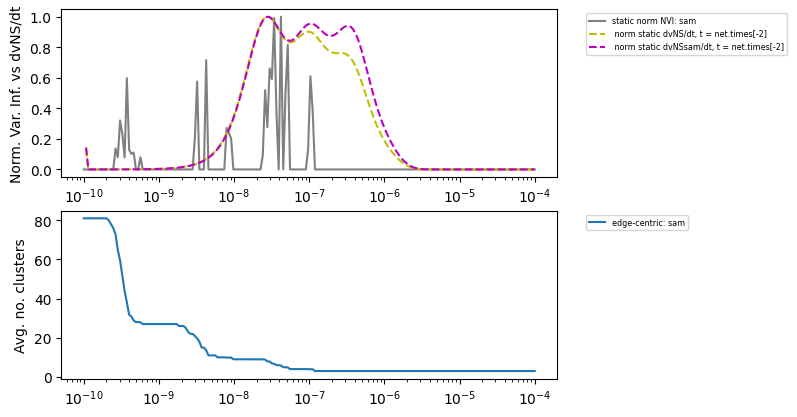

In [18]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=False)

#ax1.plot(slow_lamdas, NVI_forw_static_weighted_heat / max(NVI_forw_static_weighted_heat), 'black', label='static norm NVI: Integral')
ax1.plot(slow_lamdas, NVI_forw_static_weighted_heat_sam / max(NVI_forw_static_weighted_heat_sam) , 'grey', label='static norm NVI: sam')
ax1.plot(slow_lamdas[1:], ds_dt / min(ds_dt), 'y--', label=' norm static dvNS/dt, t = net.times[-2]')
ax1.plot(slow_lamdas[1:], dssam_dt / min(dssam_dt), 'm--', label=' norm static dvNSsam/dt, t = net.times[-2]')
ax1.set_xscale('log')


ax1.set_ylabel('Norm. Var. Inf. vs dvNS/dt')
ax1.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

# ax2.plot(lamdas, NVI_forw_heat / max(NVI_forw_heat), 'grey', label='norm NVI')
# ax2.plot(lamdas[1:], ds7_dt / min(ds7_dt), 'y', label=' norm dvNS/dt, t = net.times[-2]')
ax2.plot(slow_lamdas, avg_csize_forw_static_weighted_heat_sam, '-', label='edge-centric: sam')

ax2.set_xscale('log')

# ax2.set_ylabel('Norm. Var. Inf. vs dvNS/dt')
ax2.set_ylabel('Avg. no. clusters')
ax2.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

In [59]:
slow_lamdas

array([1.00000000e-10, 1.07189132e-10, 1.14895100e-10, 1.23155060e-10,
       1.32008840e-10, 1.41499130e-10, 1.51671689e-10, 1.62575567e-10,
       1.74263339e-10, 1.86791360e-10, 2.00220037e-10, 2.14614120e-10,
       2.30043012e-10, 2.46581108e-10, 2.64308149e-10, 2.83309610e-10,
       3.03677112e-10, 3.25508860e-10, 3.48910121e-10, 3.73993730e-10,
       4.00880633e-10, 4.29700470e-10, 4.60592204e-10, 4.93704785e-10,
       5.29197874e-10, 5.67242607e-10, 6.08022426e-10, 6.51733960e-10,
       6.98587975e-10, 7.48810386e-10, 8.02643352e-10, 8.60346442e-10,
       9.22197882e-10, 9.88495905e-10, 1.05956018e-09, 1.13573336e-09,
       1.21738273e-09, 1.30490198e-09, 1.39871310e-09, 1.49926843e-09,
       1.60705282e-09, 1.72258597e-09, 1.84642494e-09, 1.97916687e-09,
       2.12145178e-09, 2.27396575e-09, 2.43744415e-09, 2.61267523e-09,
       2.80050389e-09, 3.00183581e-09, 3.21764175e-09, 3.44896226e-09,
       3.69691271e-09, 3.96268864e-09, 4.24757155e-09, 4.55293507e-09,
      

In [66]:
with open(f'//scratch/tmp/180/skoove/experiment250_static_weighted_heat/T_slow/T{5.60716994e-09:.11f}', 'rb') as f:
    T_list = pickle.load(f)['T']

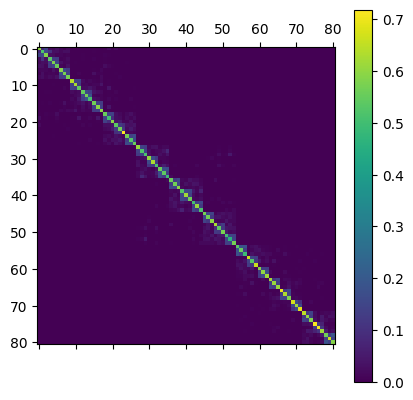

In [67]:
plt.matshow(T_list[-1].toarray())
plt.colorbar()

In [60]:

with open(f'//scratch/tmp/180/skoove/experiment250_static_weighted_heat/T_slow/T{5.17092024e-08:.11f}', 'rb') as f:
    T = pickle.load(f)['T'][-1]

PT = P @ T
sam = sparse_autocov_mat(PT, p1, p2, PT_symmetric=True)
S = sam.from_T(T = T, p1 = p1, p2 = p2)

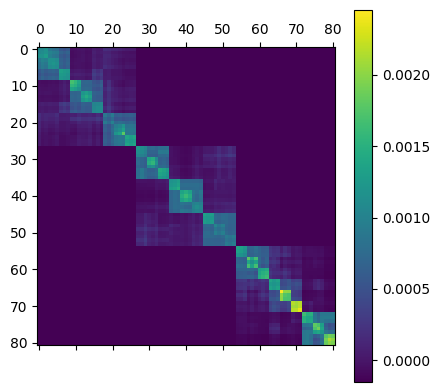

In [61]:
plt.matshow(S.toarray())
plt.colorbar()